# Chapter 2 - Exercise 4
#### Author: *John Benedick Estrada*
---
**Exercise:** There are actually two kinds of ER graphs.  The one we generated in the chapter, $G(n, p)$, is characterized by two parameters, the number of nodes and the probability of an edge between nodes.

An alternative definition, denoted $G(n, m)$, is also characterized by two parameters: the number of nodes, $n$, and the number of edges, $m$.  Under this definition, the number of edges is fixed, but their location is random.

Repeat the experiments we did in this chapter using this alternative definition.  Here are a few suggestions for how to proceed:

1. Write a function called `m_pairs` that takes a list of nodes and the number of edges, $m$, and returns a random selection of $m$ edges.  A simple way to do that is to generate a list of all possible edges and use `random.sample`.

2. Write a function called `make_m_graph` that takes $n$ and $m$ and returns a random graph with $n$ nodes and $m$ edges.

3. Make a version of `prob_connected` that uses `make_m_graph` instead of `make_random_graph`.

4. Compute the probability of connectivity for a range of values of $m$.

How do the results of this experiment compare to the results using the first type of ER graph?

In [1]:
%matplotlib inline

import random
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

from typing import Iterator, Tuple         # For type hints.

In [2]:
# Set seed to have consistent results.
random.seed(0)

#### Implementation of `m_graph`

##### Function definitions directly lifted from the book

In [3]:
def all_pairs(nodes: Iterator):
    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            if i < j:
                yield u, v

In [4]:
def three_frame(world, n_seq, seed=17):
    """Draw three timesteps.
    
    world: object with step, loop, and draw
    n_seq: 3-tuple, number of steps before each draw
    seed: random see for NumPy
    """
    np.random.seed(seed)
    plt.figure(figsize=(10, 4))

    for i, n in enumerate(n_seq):
        plt.subplot(1, 3, i+1)
        world.loop(n)
        world.draw()

    plt.tight_layout()


def underride(d, **options):
    """Add key-value pairs to d only if key is not in d.
    d: dictionary
    options: keyword args to add to d
    """
    for key, val in options.items():
        d.setdefault(key, val)

    return d


def legend(**options):
    """Draws a legend only if there is at least one labeled item.
    options are passed to plt.legend()
    https://matplotlib.org/api/_as_gen/matplotlib.pyplot.legend.html
    """
    underride(options, loc="best", frameon=False)

    ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels, **options)


def decorate(**options):
    """Decorate the current axes.
    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')
    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    In addition, you can use `legend=False` to suppress the legend.
    And you can use `loc` to indicate the location of the legend
    (the default value is 'best')
    """
    loc = options.pop("loc", "best")
    if options.pop("legend", True):
        legend(loc=loc)

    plt.gca().set(**options)
    plt.tight_layout()

##### Implementation proper

In [5]:
def reachable_nodes_precheck(G, start):
    seen = set()
    stack = [start]
    while stack:
        node = stack.pop()
        if node not in seen:
            seen.add(node)
            for neighbor in G.neighbors(node):
                if neighbor not in seen:
                    seen.add(neighbor)
    return seen

def is_connected(G: nx.Graph):
    start = next(iter(G))
    reachable = reachable_nodes_precheck(G, start)
    return len(reachable) == len(G)

In [34]:
def m_pairs(nodes: Iterator, m: int):
    """
    Randomly select `m` number of edges from all possible edges that can be
    formed with the given set of nodes `nodes`.
    """
    yield from random.sample(list(all_pairs(nodes)), m)


def make_m_graph(n: int, m: int):
    """
    Make a random graph with `n` number of nodes and `m` number of edges.
    """
    G = nx.Graph()
    nodes = range(n)
    rand_pairs = m_pairs(nodes, m)
    G.add_nodes_from(nodes)
    G.add_edges_from(rand_pairs)
    return G


def prob_connected(n: int, m: int, iters: int=100):
    """
    `prob_connected`
    Compute the probability of connectivity.
    """
    tf = [is_connected(make_m_graph(n, m))
          for i in range(iters)]
    return np.mean(tf)

##### Implementation of memoized `make_m_graph`
NOTE: This is the implementation used in getting probability of connectivity.

In [51]:
def m_pairs_with_range(n: int, m: int, __all_pairs: dict={}):
    """
    Randomly select `m` number of edges from all possible edges that can be
    formed with the given set of integer nodes.
    
    This stores generated list of edges for given `n`.
    """
    # Try to get the pre-calculated list of all possible edges.
    try:
        all_pair_list = __all_pairs[n]
    except KeyError:
        all_pair_list = list(all_pairs(range(n)))
        __all_pairs[n] = all_pair_list

    yield from random.sample(all_pair_list, m)


def memoized_make_m_graph(n: int, m: int):
    """
    Make a random graph with `n` number of nodes and `m` number of edges.
    
    This uses `m_pairs_with_range` instead of `m_pairs`.
    """
    G = nx.Graph()
    nodes = range(n)
    rand_pairs = m_pairs_with_range(n, m)
    G.add_nodes_from(nodes)
    G.add_edges_from(rand_pairs)
    return G


def memoized_prob_connected(n: int, m: int, iters: int=100):
    """
    `prob_connected`
    Compute the probability of connectivity.
    """
    tf = [is_connected(memoized_make_m_graph(n, m))
          for i in range(iters)]
    return np.mean(tf)

The memoized version of `make_m_graph` is faster for a given set of inputs than the original `make_m_graph`.

In [50]:
%timeit make_m_graph(100, 100)
%timeit memoized_make_m_graph(100, 100)

875 µs ± 18.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
173 µs ± 1.77 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


#### Example of `make_m_graph`

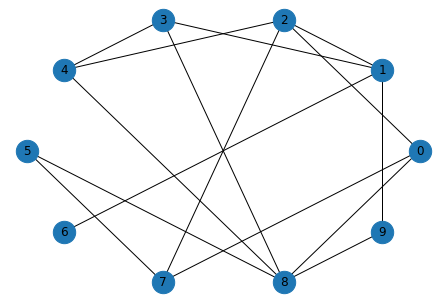

In [37]:
rand_graph = make_m_graph(n=10, m=15)
nx.draw_circular(rand_graph, 
                 node_color="C0", 
                 node_size=500, 
                 with_labels=True)

#### Probability of connectivity across all possible values of `m`

In [62]:
node_counts = [300, 100, 30]
max_m_num = 30
x_lower, x_upper = 1, 1

for n in node_counts:
    print(f"Current `n` value: {n}")

    # `max_m`: Maximum number of edges possible given the number of nodes.
    # TODO: Source this
    max_m = int(n*(n - 1)/2)
    
    # NOTE: Cast to `set` to compress the range of `m` values.
    m_range = sorted(set(np.linspace(0, max_m, num=max_m_num, dtype=int)))
    m_prob = [memoized_prob_connected(n, m) for m in m_range]
    plt.plot(m_range, m_prob, ":.", label=f"n = {n}")

    if x_lower > m_range[0] and m_range[0] > 0:
        x_lower = m_range
    if x_upper < m_range[-1]:
        x_upper = m_range[-1]


decorate(xlabel='Prob of edge (p)',
         ylabel='Number of edges',
         xscale='log', 
         xlim=(x_lower, x_upper),
         loc='upper left')

plt.show()

Current `n` value: 300
[0, 1546, 3093, 4639, 6186, 7732, 9279, 10825, 12372, 13918, 15465, 17012, 18558, 20105, 21651, 23198, 24744, 26291, 27837, 29384, 30931, 32477, 34024, 35570, 37117, 38663, 40210, 41756, 43303, 44850]


KeyboardInterrupt: 